# Notebook from FP, QAT to hls for lower total bits(8, 6, 4)

## There are two phases for QAT

1. FP model training
2. Full quantized model QAT

In [1]:
# total bit setting
total_bit = 8

# Set to True to do phase 1, otherwise load the previous saved model
retrain_fp_model = False
# Set to True to do phase 2, otherwise load the previous saved model
all_quantized_retrain = False

# hls model output directory and precision setting
hls_model_output_dir  = './hls_model/lfad_qmodel_' + str(total_bit)
hls_default_precision = 'ap_fixed<22,6>'

In [2]:
%config Completer.use_jedi = False

import sys
sys.path.append('..')

import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

use_cpu = True
cuda_device = '0'

if use_cpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    os.environ['CPU_ONLY'] = "TRUE"
    physical_devices = tf.config.list_physical_devices('CPU')
    tf.config.set_logical_device_configuration(
        physical_devices[0],
        [tf.config.LogicalDeviceConfiguration() for i in range(8)])
    logical_devices = tf.config.list_logical_devices('CPU')

    print(logical_devices)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = cuda_device
    os.environ['CPU_ONLY'] = "FALSE"
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    
from collections import defaultdict
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from tndm.data import DataManager
from tndm import LFADS
from tndm.runtime import Runtime, ModelType
from tndm.utils import AdaptiveWeights
from tndm.models.model_loader import ModelLoader

from sklearn.linear_model import Ridge

from plotting import *

2024-05-20 19:25:44.455257: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-20 19:25:44.455472: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: buyatti
2024-05-20 19:25:44.455480: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: buyatti
2024-05-20 19:25:44.455684: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.5
2024-05-20 19:25:44.455733: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.5
2024-05-20 19:25:44.455740: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.73.5
2024-05-20 19:25:44.456563: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:CPU:1', device_type='CPU'), LogicalDevice(name='/device:CPU:2', device_type='CPU'), LogicalDevice(name='/device:CPU:3', device_type='CPU'), LogicalDevice(name='/device:CPU:4', device_type='CPU'), LogicalDevice(name='/device:CPU:5', device_type='CPU'), LogicalDevice(name='/device:CPU:6', device_type='CPU'), LogicalDevice(name='/device:CPU:7', device_type='CPU')]


In [3]:
# read the data/disk/scratch/cole/Chewie_CO_FF_2016-10-07_pos_M1_spikes/test_data/
spike_data_dir = "Chewie_CO_FF_2016-10-07_pos_M1_spikes/"

data_dir = os.path.join( spike_data_dir )

dataset, settings = DataManager.load_dataset(
    directory=data_dir,
    filename='dataset.h5')

# test set is combined valid and test
neural_data = dataset['train_data'].astype('float')
valid_neural_data = dataset['valid_data'].astype('float')
test_neural_data = dataset['test_data'].astype('float')

behavioural_data = dataset['train_behaviours'].astype('float')
valid_behavioural_data = dataset['valid_behaviours'].astype('float')
test_behavioural_data = dataset['test_behaviours'].astype('float')

# center behaviour at zero, using first time step (not strictly required)
b_mean = np.mean(np.vstack((behavioural_data, test_behavioural_data, valid_behavioural_data))[:,0,:],axis=0)
for i in range(2):
    behavioural_data[:,:,i] = behavioural_data[:,:,i]-b_mean[i]
    valid_behavioural_data[:,:,i] = valid_behavioural_data[:,:,i]-b_mean[i]
    test_behavioural_data[:,:,i] = test_behavioural_data[:,:,i]-b_mean[i]

# for plotting
d_all = np.concatenate((dataset['train_target_direction'], dataset['test_target_direction'], dataset['valid_target_direction']))
d = dataset['train_target_direction']
direction_index_train = np.array([sorted(set(d_all)).index(i) for i in d])
d = dataset['test_target_direction']
direction_index_test = np.array([sorted(set(d_all)).index(i) for i in d])
direction_index_all = np.concatenate((direction_index_test, direction_index_train))

In [4]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
initial_neural_weight = 1.0 # weight of neural nll
initial_behaviour_weight = .2 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005
dropout = .15
seed = 0
GRU_pre_activation = False
var_min = 0.0001
prior_variance = 1

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)

layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['encoder'].update(dict(var_min=var_min, var_trainable=True))
layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

In [5]:
logdir = os.path.join( spike_data_dir, 'lfads_log_fp')
modeldir = os.path.join( spike_data_dir, 'lfads_model_fp')

In [6]:
T0 = datetime.now()

fp_model, x, y, validation_data, callbacks, adaptive_weights = Runtime.get_model(
    model_type=ModelType.LFADS,
    adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-5),
    model_settings=dict(
        factors=4,
        encoded_dim=64,
        max_grad_norm=200,
        dropout=dropout,
        prior_variance=prior_variance,
        GRU_pre_activation=GRU_pre_activation, #NEW
        timestep=settings['step'],
        seed=seed,
        quantized=False
    ),
    layers_settings=layers_settings,
    optimizer=optimizer, 
    epochs=1000, 
    logdir=logdir,
    train_dataset=(neural_data, behavioural_data), 
    val_dataset=(valid_neural_data, valid_behavioural_data),
    adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 1000, 1000, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    ),
    batch_size=16,
    verbose=2 # set to 2 to see the losses during training
)
if retrain_fp_model:
    history = fp_model.fit(
        x=x,
        y=y,
        callbacks=callbacks,
        shuffle=True,
        epochs=1000,
        batch_size=16,
        validation_data=validation_data,
        verbose=2
    )

    fp_model.save(modeldir)

    print('Training took '+str(datetime.now()-T0))

2024-05-20 19:25:47.975937: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-05-20 19:25:47.976199: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-05-20 19:25:48.018855: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [7]:
print(modeldir)
fp_model = ModelLoader.load(modeldir, model_class=LFADS)

Chewie_CO_FF_2016-10-07_pos_M1_spikes/lfads_model_fp


# Latent space

## Training data

In [8]:
log_f, (g0, mean, logvar), z =  fp_model(neural_data.astype('float'), training=False)

/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Factors')

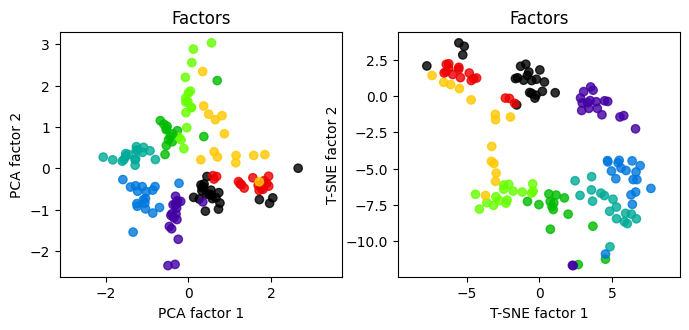

In [9]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(8,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(mean)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('T-SNE factor 1')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


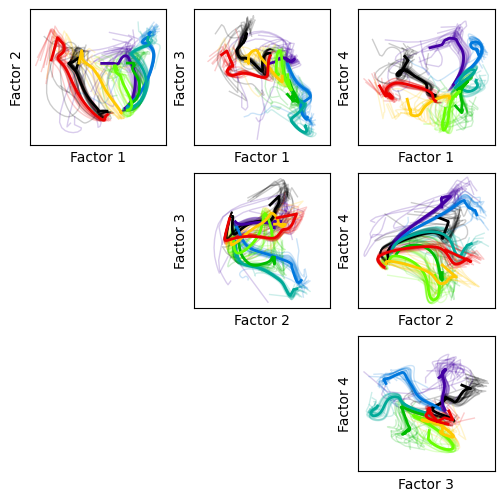

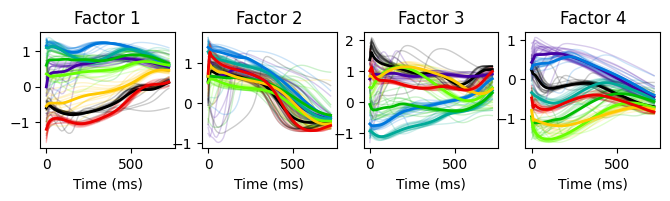

In [10]:
# latent factors
plt.figure(figsize=(6,6))
plot_all_2factors(z, direction_index_train)
plt.figure(figsize=(8,1.5))
plot_all_1factors(z, direction_index_train)


In [11]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]

/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


0.9234344953971952


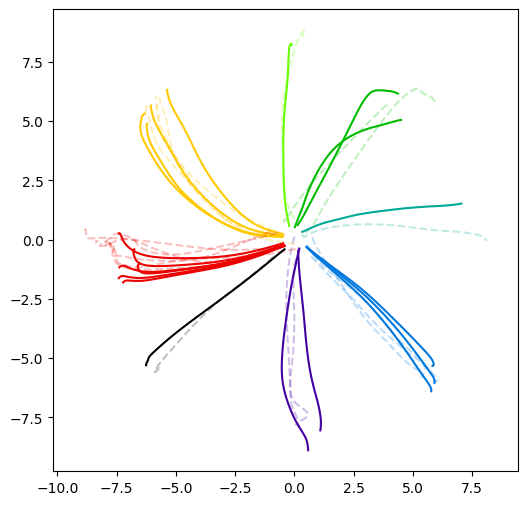

In [12]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b, behavioural_data, direction_index_train, num=20)

In [13]:
Xt = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
yt = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 92.343%


## Test data

In [14]:
log_f_t, (g0_t, mean_t, logvar_t), z_t = \
    fp_model(test_neural_data.astype('float'), training=False)

/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Factors')

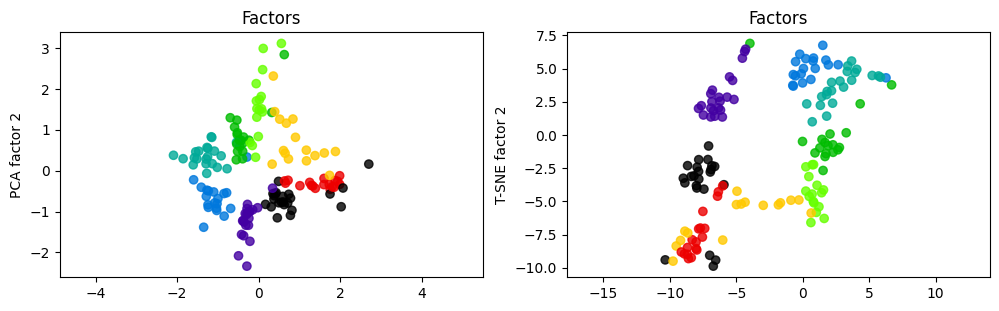

In [15]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(12,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


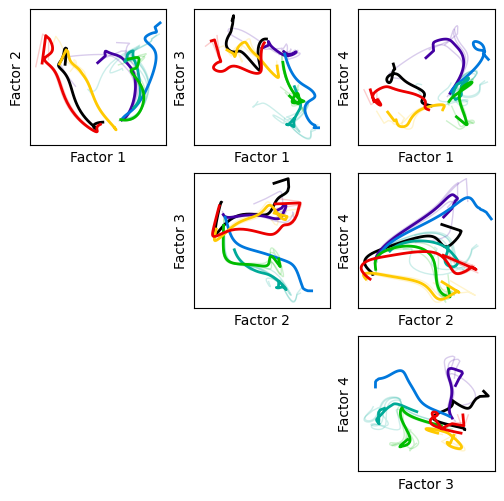

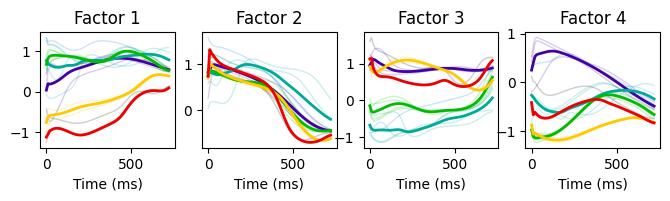

In [16]:
# relevant factors
plt.figure(figsize=(6,6))
plot_all_2factors(z_t, direction_index_test)
# relevant factors
plt.figure(figsize=(8,1.5))
plot_all_1factors(z_t, direction_index_test)


In [17]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = np.transpose(z_t.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit[:,test_behavioural_data.shape[1]:]

/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


0.9262588988194681


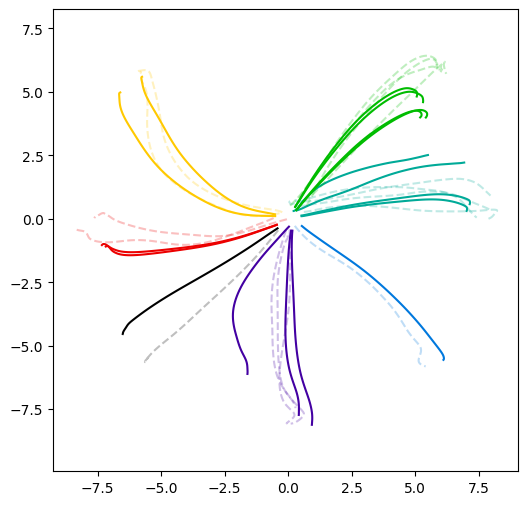

In [18]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)
# plot_behaviour(b, behavioural_data, direction_index_train)

In [19]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 92.626%


# Trial-averaged firing rates and predictions
Computed from test+train data for better averages

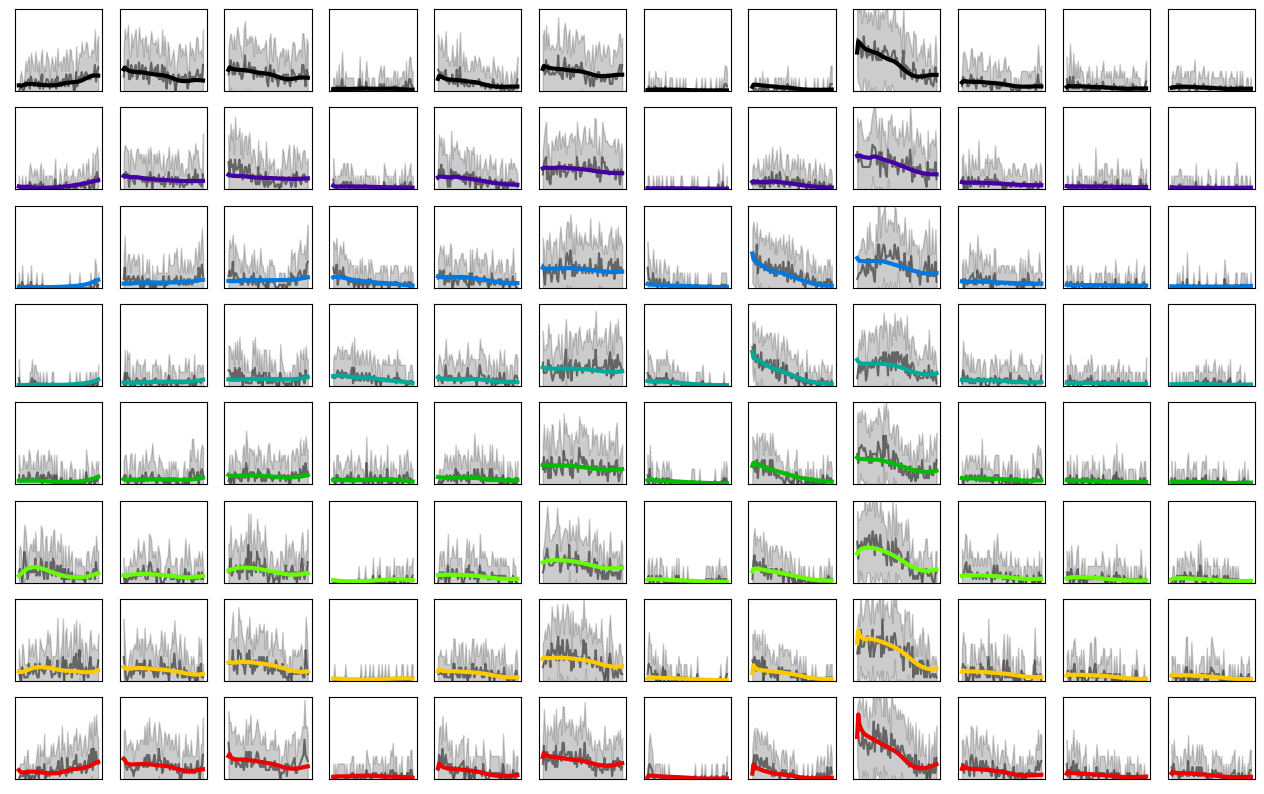

In [20]:
fig = plt.figure(figsize=(16,10))
colors = plt.cm.nipy_spectral(np.arange(8)/8)
for i in range(8):
    data = np.vstack((test_neural_data, neural_data))[direction_index_all==i,:,:]
    
    for i_n,n in enumerate(range(0,12)):
        ax = fig.add_subplot(8, 12, i*12+i_n+1)
        pred = np.vstack((np.exp(log_f_t)*settings['step'], np.exp(log_f)*settings['step']))[np.array(direction_index_all)==i,:,n]
        x = np.arange(data.shape[1])
        ax.plot(x,np.mean(data,axis=0)[:,n],'k',alpha=0.5);
        ax.fill_between(x,np.mean(data,axis=0)[:,n]-np.std(data,axis=0)[:,n], np.mean(data,axis=0)[:,n]+np.std(data,axis=0)[:,n], alpha=0.2, color='k');
        ax.plot(x,np.mean(pred,axis=0),lw=3, color=colors[i]);
        ax.set_xticks(())
        ax.set_yticks(())
        plt.ylim(0,1.5)
    

In [21]:
fp_model.summary()

Model: "lfads_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
EncoderRNN (Bidirectional)   multiple                  52224     
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
dropout_5 (Dropout)          multiple                  0         
_________________________________________________________________
DenseMean (Dense)            multiple                  8256      
_________________________________________________________________
DenseLogVar (Dense)          multiple                  8256      
_________________________________________________________________
GaussianSampling (GaussianSa multiple                  0   

In [22]:
fp_model.quantized

False

# All layers Quantized QAT

In [23]:
# qat model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
initial_neural_weight = 1.0 # weight of neural nll
initial_behaviour_weight = .2 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005
dropout = .15
seed = 0
GRU_pre_activation = False
var_min = 0.0001
prior_variance = 1

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)

layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['encoder'].update(dict(var_min=var_min, var_trainable=True))
layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

In [24]:
logdir = os.path.join( spike_data_dir, 'lfads_log_'+str(total_bit))
modeldir = os.path.join( spike_data_dir, 'lfads_model_'+str(total_bit))

In [25]:
T0 = datetime.now()

qat_model, x, y, validation_data, callbacks, adaptive_weights = Runtime.get_model(
    model_type=ModelType.LFADS,
    adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-6),
    model_settings=dict(
        factors=4,
        encoded_dim=64,
        max_grad_norm=200,
        dropout=dropout,
        prior_variance=prior_variance,
        GRU_pre_activation=GRU_pre_activation, #NEW
        timestep=settings['step'],
        seed=seed,
        quantized=True,
        total_bit=total_bit
    ),
    layers_settings=layers_settings,
    optimizer=optimizer, 
    epochs=1000, 
    logdir=logdir,
    train_dataset=(neural_data, behavioural_data), 
    val_dataset=(valid_neural_data, valid_behavioural_data),
    adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 1000, 1000, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    ),
    batch_size=16,
    verbose=2 # set to 2 to see the losses during training
)

qat_model.load_model_weight(fp_model)

if all_quantized_retrain:
    history = qat_model.fit(
        x=x,
        y=y,
        callbacks=callbacks,
        shuffle=True,
        epochs=200,
        batch_size=16,
        validation_data=validation_data,
        verbose=2
    )

    qat_model.save(modeldir)

    print('Training took '+str(datetime.now()-T0))

2024-05-20 19:30:55.061150: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-05-20 19:30:55.061416: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-05-20 19:30:55.061461: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [26]:
print(modeldir)
qat_model = ModelLoader.load(modeldir, model_class=LFADS)

Chewie_CO_FF_2016-10-07_pos_M1_spikes/lfads_model_8


# Latent space

## Training data

In [27]:
log_f, (g0, mean, logvar), z =  qat_model(neural_data.astype('float'), training=False)

/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Factors')

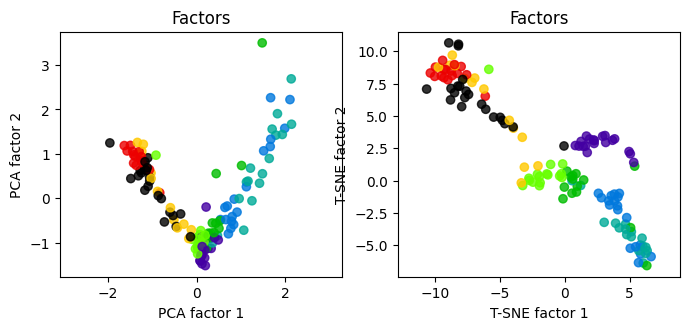

In [28]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(8,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(mean)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('T-SNE factor 1')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


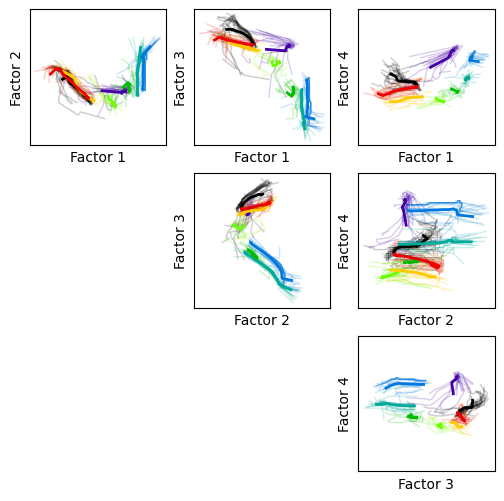

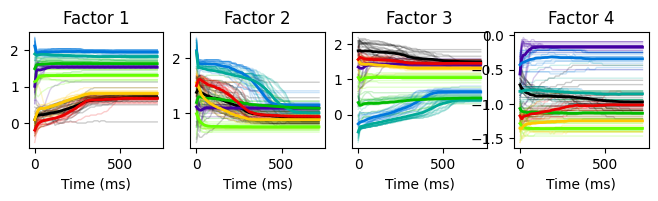

In [29]:
# latent factors
plt.figure(figsize=(6,6))
plot_all_2factors(z, direction_index_train)
plt.figure(figsize=(8,1.5))
plot_all_1factors(z, direction_index_train)


In [30]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]

/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


0.8708501878092365


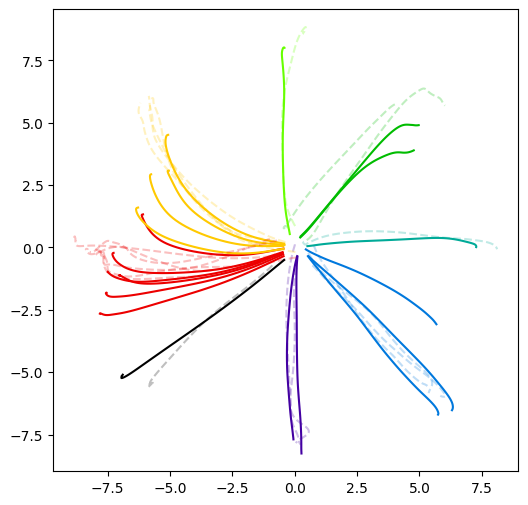

In [31]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b, behavioural_data, direction_index_train, num=20)

In [32]:
Xt = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
yt = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 87.085%


## Test data

In [33]:
log_f_t, (g0_t, mean_t, logvar_t), z_t = \
    qat_model(test_neural_data.astype('float'), training=False)

/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Factors')

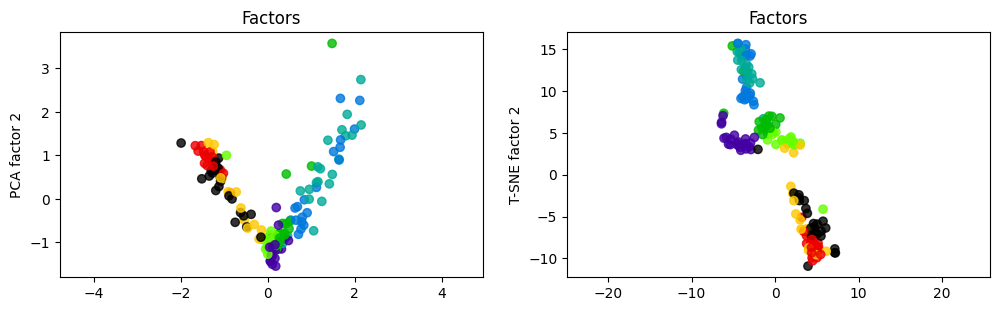

In [34]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(12,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


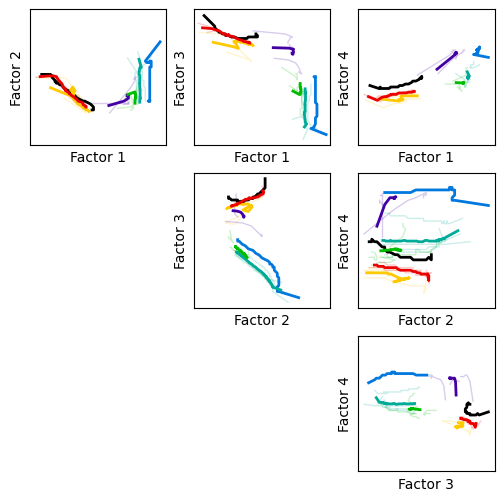

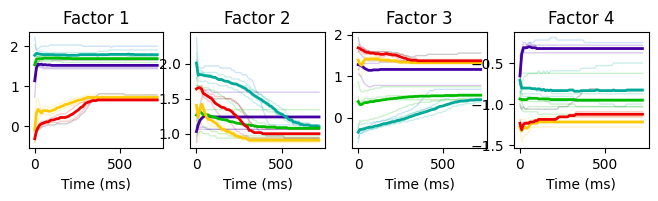

In [35]:
# relevant factors
plt.figure(figsize=(6,6))
plot_all_2factors(z_t, direction_index_test)
# relevant factors
plt.figure(figsize=(8,1.5))
plot_all_1factors(z_t, direction_index_test)


In [36]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = np.transpose(z_t.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit[:,test_behavioural_data.shape[1]:]

0.770793109705168


/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


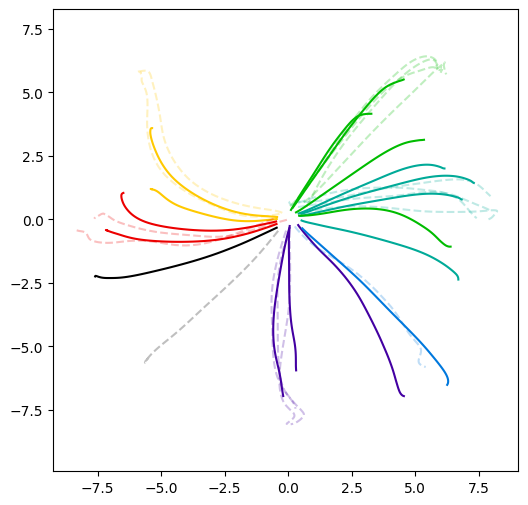

In [37]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)
# plot_behaviour(b, behavioural_data, direction_index_train)

In [38]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 77.079%


# Trial-averaged firing rates and predictions
Computed from test+train data for better averages

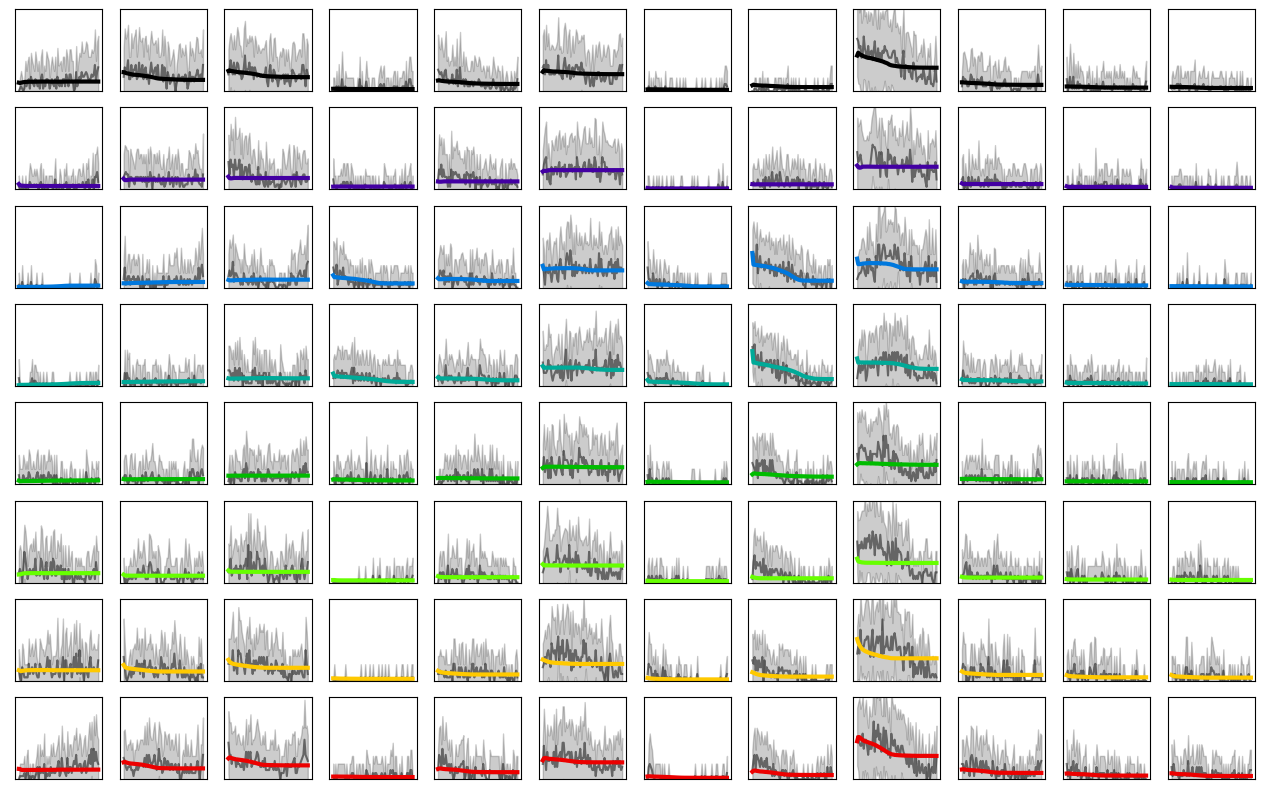

In [39]:
fig = plt.figure(figsize=(16,10))
colors = plt.cm.nipy_spectral(np.arange(8)/8)
for i in range(8):
    data = np.vstack((test_neural_data, neural_data))[direction_index_all==i,:,:]
    
    for i_n,n in enumerate(range(0,12)):
        ax = fig.add_subplot(8, 12, i*12+i_n+1)
        pred = np.vstack((np.exp(log_f_t)*settings['step'], np.exp(log_f)*settings['step']))[np.array(direction_index_all)==i,:,n]
        x = np.arange(data.shape[1])
        ax.plot(x,np.mean(data,axis=0)[:,n],'k',alpha=0.5);
        ax.fill_between(x,np.mean(data,axis=0)[:,n]-np.std(data,axis=0)[:,n], np.mean(data,axis=0)[:,n]+np.std(data,axis=0)[:,n], alpha=0.2, color='k');
        ax.plot(x,np.mean(pred,axis=0),lw=3, color=colors[i]);
        ax.set_xticks(())
        ax.set_yticks(())
        plt.ylim(0,1.5)
    

In [40]:
qat_model.summary()

Model: "lfads_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_9 (Dropout)          multiple                  0         
_________________________________________________________________
EncoderRNN (QBidirectional)  multiple                  52224     
_________________________________________________________________
q_act_postencoder (QActivati multiple                  0         
_________________________________________________________________
dropout_10 (Dropout)         multiple                  0         
_________________________________________________________________
dropout_11 (Dropout)         multiple                  0         
_________________________________________________________________
DenseMean (QDense)           multiple                  8256      
_________________________________________________________________
DenseLogVar (QDense)         multiple                  8256

# Turn customized model to h5 format

In [41]:
decoder_dim = 64
def get_decoder_input(decoder_dim=64):
    inputs2decoder_train = tf.stack([tf.zeros_like(neural_data)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_val = tf.stack([tf.zeros_like(valid_neural_data)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_test = tf.stack([tf.zeros_like(test_neural_data)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_train = np.array(inputs2decoder_train)
    inputs2decoder_val = np.array(inputs2decoder_val)
    inputs2decoder_test = np.array(inputs2decoder_test)
    print("inputs2decoder_train shape: ", inputs2decoder_train.shape)
    print("inputs2decoder_val shape: ", inputs2decoder_val.shape)
    print("inputs2decoder_test shape: ", inputs2decoder_test.shape)
    return inputs2decoder_train, inputs2decoder_val, inputs2decoder_test
inputs2decoder_train, inputs2decoder_val, inputs2decoder_test = get_decoder_input(decoder_dim=decoder_dim)

inputs2decoder_train shape:  (136, 73, 64)
inputs2decoder_val shape:  (17, 73, 64)
inputs2decoder_test shape:  (17, 73, 64)


In [42]:
qat_model.summary()

Model: "lfads_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_9 (Dropout)          multiple                  0         
_________________________________________________________________
EncoderRNN (QBidirectional)  multiple                  52224     
_________________________________________________________________
q_act_postencoder (QActivati multiple                  0         
_________________________________________________________________
dropout_10 (Dropout)         multiple                  0         
_________________________________________________________________
dropout_11 (Dropout)         multiple                  0         
_________________________________________________________________
DenseMean (QDense)           multiple                  8256      
_________________________________________________________________
DenseLogVar (QDense)         multiple                  8256

In [43]:
from tensorflow.keras import Model
import tensorflow.keras.layers as tfl
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

In [44]:
import qkeras
from qkeras.utils import load_qmodel

In [45]:
input_shape = (73,70)
inputs = tfl.Input(shape=input_shape, name = 'encoder_input')
decode_input_shape = (73,decoder_dim)
decode_inputs = tfl.Input(shape=decode_input_shape, name = 'decoder_input')

In [46]:
encoder_GRU = qat_model.get_layer("EncoderRNN")
dense_mean = qat_model.get_layer("DenseMean")
dense_logvar = qat_model.get_layer("DenseLogVar")
decoder_GRU = qat_model.get_layer("DecoderGRU")
dense = qat_model.get_layer("Dense")
neural_dense = qat_model.get_layer("NeuralDense")
# Activation
q_act_dense_mean = qat_model.get_layer("q_act_dense_mean")
q_act_dense_logvar = qat_model.get_layer("q_act_dense_logvar")
q_act_postencoder = qat_model.get_layer("q_act_postencoder")
q_act_postsampling = qat_model.get_layer("q_act_postsampling")
q_act_predecoder = qat_model.get_layer("q_act_predecoder")
q_act_postdecoder = qat_model.get_layer("q_act_postdecoder")
q_act_postdense = qat_model.get_layer("q_act_postdense")

In [47]:
# encode
encoder_GRU_out = encoder_GRU(inputs)
q_act_postencoder_out = q_act_postencoder(encoder_GRU_out)
dense_mean_out = dense_mean(q_act_postencoder_out)
q_act_dense_mean_out = q_act_dense_mean(dense_mean_out)
dense_logvar_out = dense_logvar(q_act_postencoder_out)
q_act_dense_logvar_out = q_act_dense_logvar(dense_logvar_out)
#dense_logvar_out = tf.math.log(tf.exp(dense_logvar_out + 0.0001))

#epsilon = StandardRandomNormal()(q_act_dense_mean_out)

#z_var = ExponentLogvar()(q_act_dense_logvar_out)

#z_var = tfl.Multiply()([z_var, epsilon])

#z_out = tfl.Add()([q_act_dense_mean_out, z_var])

#q_act_postsampling_out = q_act_postsampling(z_out)
q_act_postsampling_out = q_act_postsampling(q_act_dense_mean_out)

# decode
q_act_predecoder_out = q_act_predecoder(q_act_postsampling_out)
decoder_GRU_out = decoder_GRU(decode_inputs, initial_state = q_act_predecoder_out)
q_act_postdecoder_out = q_act_postdecoder(decoder_GRU_out)
dense_out = dense(q_act_postdecoder_out)
q_act_postdense_out = q_act_postdense(dense_out)
neural_dense_out = neural_dense(q_act_postdense_out)

In [48]:
lfad_full = Model(inputs = [inputs, decode_inputs], outputs = [dense_out, neural_dense_out], name="lfad_full")

In [49]:
plot_model(lfad_full)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [50]:
z, _ =  lfad_full.predict([neural_data.astype('float'), inputs2decoder_train])
X = np.transpose(z[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]
b_reshape = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
behavioural_data_reshape  = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
r2 = r2_score(behavioural_data_reshape , b_reshape)
print('h5 qmodel train behaviour R2 score : {:.3%}'.format(r2))

/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-05-20 19:35:57.632533: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


h5 qmodel train behaviour R2 score : 87.085%


/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [51]:
pred_z_test, _ =  lfad_full.predict([test_neural_data.astype('float'), inputs2decoder_val])
Xt = np.transpose(pred_z_test[:,:,factors_reconstruct], (0,2,1)).reshape((pred_z_test.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('h5 qmodel test behaviour R2 score : {:.3%}'.format(reg.score(Xt, yt)))

/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


h5 qmodel test behaviour R2 score : 77.067%


In [52]:
print("model save in: "+modeldir+'.h5')
lfad_full.save(modeldir+'.h5')

model save in: Chewie_CO_FF_2016-10-07_pos_M1_spikes/lfads_model_8.h5


In [53]:
lfad_full = load_qmodel(
    modeldir+'.h5',
     compile = False
)

[19:36:05.824] INFO [root.safe_eval:125] keras dict linear
[19:36:05.835] INFO [root.safe_eval:125] keras dict linear
[19:36:05.838] INFO [root.safe_eval:125] keras dict linear


In [54]:
z, _ =  lfad_full.predict([neural_data.astype('float'), inputs2decoder_train])
X = np.transpose(z[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]
b_reshape = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
behavioural_data_reshape  = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
r2 = r2_score(behavioural_data_reshape , b_reshape)
print('h5 qmodel train behaviour R2 score : {:.3%}'.format(r2))

/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


h5 qmodel train behaviour R2 score : 87.085%


/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [55]:
pred_z_test, _ =  lfad_full.predict([test_neural_data.astype('float'), inputs2decoder_val])
Xt = np.transpose(pred_z_test[:,:,factors_reconstruct], (0,2,1)).reshape((pred_z_test.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('h5 qmodel test behaviour R2 score : {:.3%}'.format(reg.score(Xt, yt)))

/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


h5 qmodel test behaviour R2 score : 77.067%


In [56]:
lfad_full.summary()

Model: "lfad_full"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 73, 70)]     0                                            
__________________________________________________________________________________________________
EncoderRNN (QBidirectional)     (None, 128)          52224       encoder_input[0][0]              
__________________________________________________________________________________________________
q_act_postencoder (QActivation) (None, 128)          0           EncoderRNN[0][0]                 
__________________________________________________________________________________________________
DenseMean (QDense)              (None, 64)           8256        q_act_postencoder[0][0]          
__________________________________________________________________________________________

In [57]:
plot_model(lfad_full)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [58]:
import json
import pprint

In [59]:
model_arch = json.loads(lfad_full.to_json())
layer_config = model_arch['config']['layers']

In [60]:
pprint.pprint(model_arch)

{'backend': 'tensorflow',
 'class_name': 'Functional',
 'config': {'input_layers': [['encoder_input', 0, 0], ['decoder_input', 0, 0]],
            'layers': [{'class_name': 'InputLayer',
                        'config': {'batch_input_shape': [None, 73, 70],
                                   'dtype': 'float32',
                                   'name': 'encoder_input',
                                   'ragged': False,
                                   'sparse': False},
                        'inbound_nodes': [],
                        'name': 'encoder_input'},
                       {'class_name': 'QBidirectional',
                        'config': {'backward_layer': {'class_name': 'QGRU',
                                                      'config': {'activation': {'class_name': 'quantized_tanh',
                                                                                'config': {'bits': 8,
                                                                                

In [61]:
pprint.pprint(layer_config)

[{'class_name': 'InputLayer',
  'config': {'batch_input_shape': [None, 73, 70],
             'dtype': 'float32',
             'name': 'encoder_input',
             'ragged': False,
             'sparse': False},
  'inbound_nodes': [],
  'name': 'encoder_input'},
 {'class_name': 'QBidirectional',
  'config': {'backward_layer': {'class_name': 'QGRU',
                                'config': {'activation': {'class_name': 'quantized_tanh',
                                                          'config': {'bits': 8,
                                                                     'symmetric': False,
                                                                     'use_real_tanh': False,
                                                                     'use_stochastic_rounding': False}},
                                           'activity_regularizer': None,
                                           'bias_constraint': {'class_name': 'Clip',
                                  

# HLS

In [62]:
import hls4ml

/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [63]:
from hls4ml.converters.keras_to_hls import parse_default_keras_layer
from hls4ml.model.attributes import ConfigurableAttribute, TypeAttribute

In [64]:
from hls4ml.model.types import (
    #ExponentPrecisionType,
    FixedPrecisionType,
    #IntegerPrecisionType,
    RoundingMode,
    SaturationMode,
    #XnorPrecisionType,
)

# Register Layer

In [65]:
model = lfad_full

In [66]:
config = hls4ml.utils.config_from_keras_model(model, granularity='name', default_precision=hls_default_precision)
config['Model']['Strategy'] = 'Resource'

Interpreting Model
Topology:
Layer name: encoder_input, layer type: InputLayer, input shapes: [[None, 73, 70]], output shape: [None, 73, 70]
Layer name: EncoderRNN, layer type: QBidirectional, input shapes: [[None, 73, 70]], output shape: [None, 128]
Layer name: q_act_postencoder, layer type: Activation, input shapes: [[None, 128]], output shape: [None, 128]
Layer name: DenseMean, layer type: QDense, input shapes: [[None, 128]], output shape: [None, 64]
Layer name: q_act_dense_mean, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_act_postsampling, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: decoder_input, layer type: InputLayer, input shapes: [[None, 73, 64]], output shape: [None, 73, 64]
Layer name: q_act_predecoder, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: DecoderGRU, layer type: QGRU, input shapes: [[None, 73, 64], [None, 64]], output shape: [None, 

In [67]:
pprint.pprint(config)

{'LayerName': {'DecoderGRU': {'ApplyResetGate': 'after',
                              'Direction': 'forward',
                              'Precision': {'act': 'ap_fixed<22,6>',
                                            'activation': 'fixed<8,1,RND_CONV,SAT>',
                                            'bias': 'fixed<8,2>',
                                            'recr_act': 'ap_fixed<22,6>',
                                            'recurrent_activation': 'ufixed<8,0,RND_CONV,SAT>',
                                            'recurrent_bias': 'fixed<8,2>',
                                            'recurrent_weight': 'fixed<8,2>',
                                            'result': 'ap_fixed<22,6>',
                                            'shift': 'ap_fixed<22,6>',
                                            'slope': 'ap_fixed<22,6>',
                                            'state': 'fixed<8,3>',
                                            'weight': 'fixed<8,2

In [68]:
def evaluate_NPLL(targets, pred_logrates):
    targets = tf.cast(targets, dtype=tf.float32)
    logrates = tf.cast(tf.math.log(0.01) + pred_logrates, tf.float32)  # Timestep
    npll = tf.nn.log_poisson_loss(targets=targets,log_input=logrates, compute_full_loss=True)
    results = tf.reduce_sum(npll, axis=[1, 2]) # sum up each batch seperately
    results = tf.reduce_mean(results) # batch mean

    return results.numpy() # negative possion loglikelihood

In [69]:
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir=hls_model_output_dir,
                                                       io_type = 'io_array_stream',
                                                       #io_type = 'io_parallel',
                                                       #backend='VivadoAccelerator', board='pynq-z2')
                                                       part='xcu250-figd2104-2L-e')
hls_model.compile()
#hls_model.write()

Interpreting Model
Topology:
Layer name: encoder_input, layer type: InputLayer, input shapes: [[None, 73, 70]], output shape: [None, 73, 70]
Layer name: EncoderRNN, layer type: QBidirectional, input shapes: [[None, 73, 70]], output shape: [None, 128]
Layer name: q_act_postencoder, layer type: Activation, input shapes: [[None, 128]], output shape: [None, 128]
Layer name: DenseMean, layer type: QDense, input shapes: [[None, 128]], output shape: [None, 64]
Layer name: q_act_dense_mean, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_act_postsampling, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: decoder_input, layer type: InputLayer, input shapes: [[None, 73, 64]], output shape: [None, 73, 64]
Layer name: q_act_predecoder, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: DecoderGRU, layer type: QGRU, input shapes: [[None, 73, 64], [None, 64]], output shape: [None, 

Done


In [70]:
_, pred_logf_keras = lfad_full.predict([test_neural_data, inputs2decoder_test])
npll_keras = evaluate_NPLL(targets=test_neural_data, pred_logrates=pred_logf_keras)

pred_logf_hls = hls_model.predict([test_neural_data, inputs2decoder_test])
npll_hls = evaluate_NPLL(targets=test_neural_data, pred_logrates=pred_logf_hls.reshape(17,73,70))

/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [71]:
print("kears lost: ", npll_keras)
print("hls model lost: ", npll_hls)

kears lost:  1824.063
hls model lost:  1844.4252


In [72]:
from sklearn.metrics import mean_absolute_error

In [73]:
mean_absolute_error(pred_logf_keras.flatten(), pred_logf_hls.flatten())

0.10613160289800852

P.S.: to reduce the mse error, please change the layer10_t in /firmware/defines.h
for example: ap_fixed<17,4> to ap_fixed<19,6>